# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: Twitter Sentiment Analysis

Sentiment Analysis refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.

Problem Statement : The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a biased (racist or sexist) sentiment associated with it. So, the task is to classify biased(racist or sexist) tweets from other tweets.

Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is biased(racist/sexist) and label ‘0’ denotes the tweet is not biased( not racist/sexist), your objective is to predict the labels on the given test dataset.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the twitter sentiments data. 

In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 


warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


%matplotlib inline

In [2]:
# Read data from train and test files
train  = pd.read_csv('train_tweets.csv')
finaltest = pd.read_csv('test_tweets.csv')

In [3]:
# Check the first few rows of the train dataset.
# The data has 3 columns id, label, and tweet.
# label is the binary target variable and tweet contains the tweets that we will clean and preprocess.

train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
train.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [5]:
# As another sanity check, let’s take a look at how many words are there in each tweet.
#train['token_length'] = [len(x.split(" ")) for x in train['tweet']]
#max(train.token_length)

# Basic feature extraction : Number of words
train['word_count'] = train['tweet'].apply(lambda x: len(str(x).split(" ")))
train[['tweet','word_count']].head()


,tweet,word_count
0,@user when a father is dysfunctional and is s...,21
1,@user @user thanks for #lyft credit i can't us...,22
2,bihday your majesty,5
3,#model i love u take with u all the time in ...,17
4,factsguide: society now #motivation,8


In [6]:
#Basic feature extraction : Number of characters
train['char_count'] = train['tweet'].str.len() ## this also includes spaces
train[['tweet','char_count']].head()

,tweet,char_count
0,@user when a father is dysfunctional and is s...,102
1,@user @user thanks for #lyft credit i can't us...,122
2,bihday your majesty,21
3,#model i love u take with u all the time in ...,86
4,factsguide: society now #motivation,39


In [7]:
# Basic feature extraction :Average Word Length
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

train['avg_word'] = train['tweet'].apply(lambda x: avg_word(x))
train[['tweet','avg_word']].head()

,tweet,avg_word
0,@user when a father is dysfunctional and is s...,4.555556
1,@user @user thanks for #lyft credit i can't us...,5.315789
2,bihday your majesty,5.666667
3,#model i love u take with u all the time in ...,4.928571
4,factsguide: society now #motivation,8.000000


In [8]:
#Basic feature extraction : Number of stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

train['stopwords'] = train['tweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['tweet','stopwords']].head()

,tweet,stopwords
0,@user when a father is dysfunctional and is s...,10
1,@user @user thanks for #lyft credit i can't us...,5
2,bihday your majesty,1
3,#model i love u take with u all the time in ...,5
4,factsguide: society now #motivation,1


In [9]:
#Basic feature extraction : Number of special characters
train['hastags'] = train['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
train[['tweet','hastags']].head()

,tweet,hastags
0,@user when a father is dysfunctional and is s...,1
1,@user @user thanks for #lyft credit i can't us...,3
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,1
4,factsguide: society now #motivation,1


In [10]:
#Basic feature extraction : Number of uppercase words
train['upper'] = train['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
train[['tweet','upper']].head()

,tweet,upper
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


In [11]:
# Now lets check the first few rows of the test dataset
# The data has 2 columns id, and tweet.
# We would be using this test file to predict the label (i.e whether it is a positive or negative tweet)
finaltest.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


Total no of tweets :31962
No of normal tweets :29720
No of biased tweets :2242


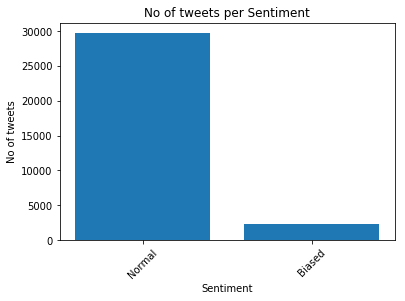

In [12]:
#Let’s take a look at the class distribution of the data.

print("Total no of tweets :{}".format(train['id'].count()))
print("No of normal tweets :{}".format(len(train[train['label'] == 0]) ))
print("No of biased tweets :{}".format(len(train[train['label'] == 1]) ))

Mood_count=train['label'].value_counts()

Index = [1,2]
plt.bar(Index,Mood_count)
plt.xticks(Index,['Normal','Biased'],rotation=45)
plt.ylabel('No of tweets')
plt.xlabel('Sentiment')
plt.title('No of tweets per Sentiment')
plt.show()

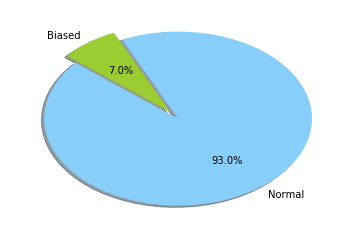

In [13]:
import matplotlib.pyplot as pltpie
 
slices_mood = Mood_count
labels =['Normal','Biased']
colors = ['lightskyblue', 'yellowgreen']
explode = [0,0.1]
pltpie.pie(slices_mood, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
pltpie.show()

We observe that the data is not well balanced, and biased class has the less number of data entries with 2242, and the Normal class has the most data with 29720 entries. We should rebalance the data so that we would have a balanced dataset at least for training. We dea will deal with this after we define the cleaning function.

Text Preprocessing and Cleaning :

Since, text is the most unstructured form of all the available data, various types of noise are present in it and the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing.

The preprocessing of the text data is an essential step as it makes the raw text ready for mining, i.e., it becomes easier to extract information from the text and apply machine learning algorithms to it. If we skip this step then there is a higher chance that you are working with noisy and inconsistent data. The objective of this step is to clean noise those are less relevant to find the sentiment of tweets such as punctuation, special characters, numbers, and terms which don’t carry much weightage in context to the text.

In one of the later stages, we will be extracting numeric features from our Twitter text data. This feature space is created using all the unique words present in the entire data. So, if we preprocess our data well, then we would be able to get a better quality feature space.

For our convenience, let’s first combine train and test set. This saves the trouble of performing the same steps twice on test and train.Later we would be splitting the data into train and test sets.

Now let’s create a new column tidy_tweet, it will contain the cleaned and processed tweets. 

In [14]:
combi = train.append(finaltest, ignore_index=True)

In [15]:
#Basic Text Pre-processing of text data : Lower Case
combi['tidy_tweet'] = combi['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
combi[['tweet','tidy_tweet']].head()

,tweet,tidy_tweet
0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is so...
1,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,bihday your majesty,bihday your majesty
3,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...
4,factsguide: society now #motivation,factsguide: society now #motivation


In [16]:
#Basic Text Pre-processing of text data : Correct Spellings 
from textblob import TextBlob
combi['tidy_tweet'][:5].apply(lambda x: str(TextBlob(x).correct()))
combi[['tweet','tidy_tweet']].head()

,tweet,tidy_tweet
0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is so...
1,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,bihday your majesty,bihday your majesty
3,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...
4,factsguide: society now #motivation,factsguide: society now #motivation


Given below is a user-defined function to remove unwanted text patterns from the tweets. It takes two arguments, one is the original string of text and the other is the pattern of text that we want to remove from the string. The function returns the same input string but without the given pattern. We will use this function to remove the pattern ‘@user’ from all the tweets in our data.

In [17]:
def remove_pattern(input_txt, pattern):
    input_txt = input_txt.strip()
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

Basic Text Pre-processing of text data : Removing Twitter Handles (@user)
As mentioned above, the tweets contain lots of twitter handles (@user), that is how a Twitter user acknowledged on Twitter. We will remove all these twitter handles from the data as they don’t convey much information.

Note that we have passed “@[\w]*” as the pattern to the remove_pattern function. It is actually a regular expression which will pick any word starting with ‘@’.

In [18]:
# Basic Text Pre-processing of text data : remove twitter handles (@user)
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")
combi[['tweet','tidy_tweet']].head()

,tweet,tidy_tweet
0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so self...
1,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,bihday your majesty,bihday your majesty
3,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,factsguide: society now #motivation,factsguide: society now #motivation


Text data often contains words or phrases which are not present in any standard lexical dictionaries. These pieces are not recognized by search engines and models.

Some of the examples are – acronyms, hashtags with attached words, and colloquial slangs. With the help of regular expressions and manually prepared data dictionaries, this type of noise can be fixed, the code below uses a dictionary lookup method to replace social media slangs from a text.

In [19]:
# Basic Text Pre-processing of text data : replacing acronyms, hashtags with attached words, and colloquial slangs
lookup_dict = {'awsm' : 'awesome','afaik':'as far as i know','ama':'ask me anything',
                'bae': 'before anyone else','bff': 'best friends forever',
                'brb': 'be right back','btw':  'by the way', 'dm':'direct message',
                'fomo':'fear of missing out','ftw':'for the win','fyi': 'for your information',
                'g+': 'google plus','gtg': 'got to go','icymi': 'in case you missed it','idc':'i dont care', 
                'idk':  'i don’t know','ily':  'i love you','ig': 'instagram',
                'imho':'in my humble opinion','imo': 'in my opinion','irl': 'in real life',
                'jk': 'just kidding','lmao':  'laughing my a** off','lmk': 'let me know',
                'lol':'laughing out loud','li': 'linkedin',  'luv' :'love','mt':'modified tweet',
                'nbd': 'no big deal','nm': 'not much','nvm': 'never mind','nsfw':'not safe for work',
                 'oh':  'overheard','omg':  'oh my god', 'omw':  'on my way','pm':'private message',
                 'podt': 'photo of the day','ppl': 'people','qotd': 'quote of the day',  'rt':'retweet', 
                 'rofl':'rolling on the floor laughing','smh': 'shaking my head','tbh':  
                 'to be honest','tbt': 'throwback Thursday','til': 'today i learned','tl;dr': 'too long; didnt read',
                 'wtf': 'what the f***','yolo': 'you only live once','yt': 'youtube','u':'you' }


def lookup_words(input_element):
    
    new_text=""
    #print(input_element)
    words = input_element.split(" ") 
    new_words = [] 
    for word in words:
        if word.lower() in lookup_dict:
            word = lookup_dict[word.lower()]
        new_words.append(word) 
        new_text = " ".join(new_words) 
    return new_text.strip()
    
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: lookup_words(x))
combi[['tweet','tidy_tweet']].head()

,tweet,tidy_tweet
0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...
2,bihday your majesty,bihday your majesty
3,#model i love u take with u all the time in ...,#model i love you take with you all the time...
4,factsguide: society now #motivation,factsguide: society now #motivation


Removing Punctuations, Numbers, and Special Characters :

As discussed, punctuations, numbers and special characters do not help much. It is better to remove them from the text just as we removed the twitter handles. Here we will replace everything except characters and hashtags with spaces.

In [20]:
# Basic Text Pre-processing of text data : Remove special characters, numbers, punctuations

def cleanse_tweet(string):

    #EMOJIS
    string = re.sub(r":\)","emojihappy1",string)
    string = re.sub(r":P","emojihappy2",string)
    string = re.sub(r":p","emojihappy3",string)
    string = re.sub(r":>","emojihappy4",string)
    string = re.sub(r":3","emojihappy5",string)
    string = re.sub(r":D","emojihappy6",string)
    string = re.sub(r" XD ","emojihappy7",string)
    string = re.sub(r" <3 ","emojihappy8",string)

    string = re.sub(r":\(","emojisad9",string)
    string = re.sub(r":<","emojisad10",string)
    string = re.sub(r":<","emojisad11",string)
    string = re.sub(r">:\(","emojisad12",string)
    
    #WEBSITES
    string = re.sub(r"http(s)*:(\S)*","linktoken",string)

    # Remove bad URLS
    string = re.sub(r'http?s:\/\/[a-zA-Z0-9]+[^a-zA-Z0-9]', ' ', string)
    
     # Remove EMails
    string = re.sub(r'[\w\.-]+@[\w\.-]+', ' ', string)
    
    # Remove Numbers
    string = re.sub(r'[0-9]+', ' ', string)
    
    # Replace terminators by space
    string = re.sub(r'[.,?!\'\"]', '', string)
    
    #STRANGE UNICODE \x...
    string = re.sub(r"\\x(\S)*","",string)
    string = re.sub(r"[^\x00-\x7F]+","", string)

    # Removenumbers and replace them with empty string for train dataset
    string = re.sub(r"\d+","",string)
    
    #General Cleanup and Symbols
    #string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
   # string = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", string)
    
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    return string.strip().lower()


combi['tidy_tweet'] =  combi['tidy_tweet'].apply(lambda x: cleanse_tweet(x))
combi[['tweet','tidy_tweet']].head()

,tweet,tidy_tweet
0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i cant use cause they ...
2,bihday your majesty,bihday your majesty
3,#model i love u take with u all the time in ...,#model i love you take with you all the time i...
4,factsguide: society now #motivation,factsguide: society now #motivation


Removing Short Words :
We have to be a little careful here in selecting the length of the words which we want to remove. So, here we'll remove all the words having length 3 or less. For example, terms like “hmm”, “oh” are of very little use. It is better to get rid of them.

In [21]:
# Basic Text Pre-processing of text data : Remove short words
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combi[['tweet','tidy_tweet']].head()

,tweet,tidy_tweet
0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cant cause they dont offer...
2,bihday your majesty,bihday your majesty
3,#model i love u take with u all the time in ...,#model love take with time
4,factsguide: society now #motivation,factsguide: society #motivation


You can see the difference between the raw tweets and the cleaned tweets (tidy_tweet) quite clearly. Only the important words in the tweets have been retained and the noise (numbers, punctuations, and special characters) has been removed.

Tokenization :
Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [22]:
#Basic Text Pre-processing of text data : Tokenization 
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
combi[['tweet','tidy_tweet']].head()

,tweet,tidy_tweet
0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cant cause they dont offer...
2,bihday your majesty,bihday your majesty
3,#model i love u take with u all the time in ...,#model love take with time
4,factsguide: society now #motivation,factsguide: society #motivation


Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than just stripping the suffices. It makes use of the vocabulary and does a morphological analysis to obtain the root word. Therefore, we usually prefer using lemmatization over stemming.

In [23]:
#Basic Text Pre-processing of text data : Lemmatization
from textblob import Word
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
combi[['tweet','tidy_tweet']].head()

,tweet,tidy_tweet
0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drag kid int...
1,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cant cause they dont offer...
2,bihday your majesty,bihday your majesty
3,#model i love u take with u all the time in ...,#model love take with time
4,factsguide: society now #motivation,factsguide: society #motivation


Visualization from Tweets
In this section, we will explore the cleaned tweets text. Exploring and visualizing data, no matter whether its text or any other data, is an essential step in gaining insights.

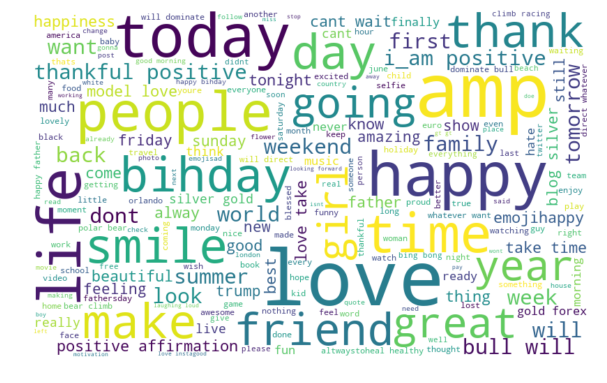

In [24]:
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color ='white').generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. With happy and love being the most frequent ones. It doesn’t give us any idea about the words associated with the biased(racist/sexist) tweets. Hence, we will plot separate wordclouds for both the classes(racist/sexist or not) in our train data.

Words in non biased (racist/sexist) tweets

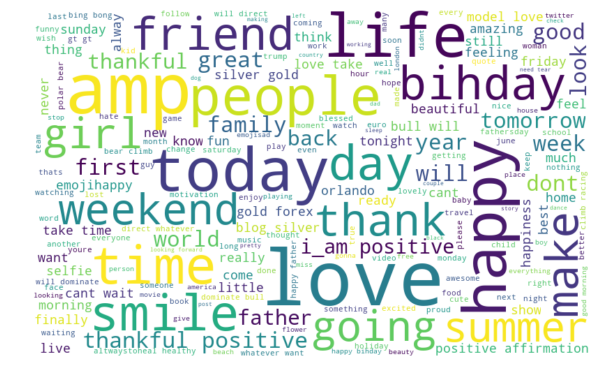

In [25]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color ='white').generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. With happy, smile, and love being the most frequent ones. Hence, most of the frequent words are compatible with the sentiment which is non biased(non racist/sexists) tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see biased (racist, and sexist) terms.

Biased (Racist/Sexist) Tweets

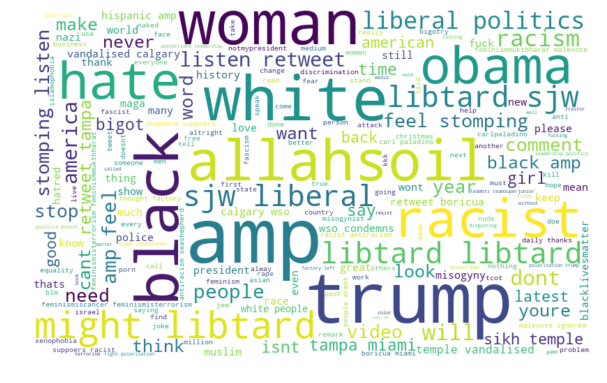

In [26]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110, background_color ='white').generate(negative_words)
plt.figure(figsize=(10, 7), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. 

Next we will the hashtags/trends in our twitter data.

Understanding the impact of Hashtags on tweets sentiment
Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.

We will store all the trend terms in two separate lists — one for non biased (non-racist/sexist) tweets and the other for biased(racist/sexist) tweets.

In [27]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [28]:
# extracting hashtags from non biased( non racist/sexist) tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

# extracting hashtags from biased (racist/sexist) tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top n hashtags. So, first let’s check the hashtags in the non-biased (non racist/sexist) tweets.

Non-biased (non Racist/Sexist) Tweets

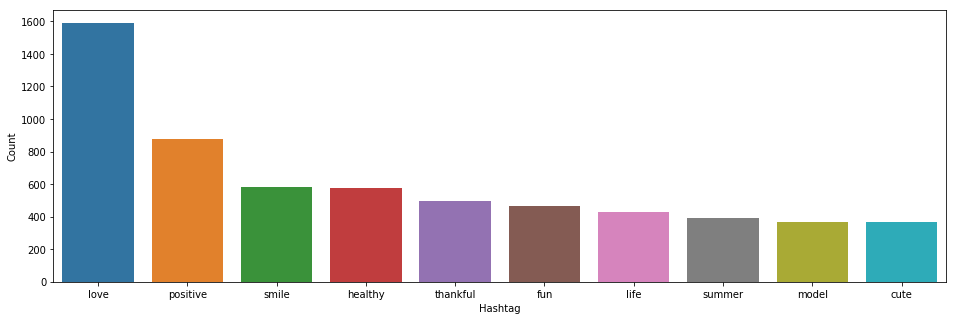

In [29]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

Let’s check the most frequent hashtags appearing in the biased (racist/sexist) tweets.

Biased (Racist/Sexist) Tweets

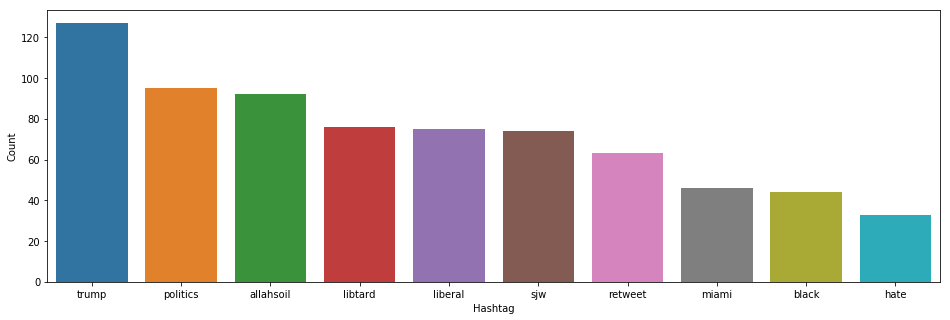

In [30]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

##Extracting Features from Cleaned Tweets :

Text data requires special preparation before you can start using it for predictive modeling.First the text has to be parsed to remove words and then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization)

Bag-of-Words Model: 

We want to perform classification of text(group of words), so each text is an “input” and a class label is the “output” for our predictive algorithm. Algorithms take vectors of numbers as input, therefore we need to convert text to fixed-length vectors of numbers.This can be achieved by using a simple and effective model called the Bag-of-Words Model, or BoW.

The model just focuses on the occurrence of words in a text.This can be done by assigning each word a unique number. Then any text we see can be encoded as a fixed-length vector with the length of the vocabulary of known words. The value in each position in the vector could be filled with a count or frequency of each word in the encoded text.

The 2 schemes provided by scikit-learn library are 

a. Word Counts with CountVectorizer : The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.

b. Word Frequencies with TfidfVectorizer : “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

Term Frequency: This summarizes how often a given word appears within a document.
Inverse Document Frequency: This downscales words that appear a lot across documents.

The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents.

IMBALANCED DATA:

Imbalanced data typically refers to a problem with classification problems where the classes are not represented equally.

In the current scenario, we have a 2-class (binary) classification problem with 31962 instances (rows). A total of 29720 instances are labeled with Class-1 and the remaining 2242 instances are labeled with Class-2. This is an imbalanced dataset and the ratio of Class-1 to Class-2 instances is 93:7.

Ignoring this problem : Building a classifier using the data as it is, would in most cases give us a prediction model that always returns the majority class. The classifier would be biased

Tactics To Combat Imbalanced Training Data :

1. Try Changing Your Performance Metric :
    
    Accuracy is not the metric to use when working with an imbalanced dataset. It is misleading.We can consider the below listed performance measures for evaluating our results.
    
    a. Confusion Matrix: A breakdown of predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned).
    b. Precision: A measure of a classifiers exactness.
    c. Recall: A measure of a classifiers completeness
    d. F1 Score (or F-score): A weighted average of precision and recall.

2. Try Resampling Your Dataset :
    
    We can change the dataset that we use to build our predictive model to have more balanced data.This change is called sampling our dataset and there are two main methods that you can use to even-up the classes:

    a. You can add copies of instances from the under-represented class called over-sampling (or more formally sampling with replacement), or
    b. You can delete instances from the over-represented class, called under-sampling.

3. Try Generate Synthetic Samples :

    A simple way to generate synthetic samples is to randomly sample the attributes from instances in the minority class.There are systematic algorithms that you can use to generate synthetic samples. The most popular of such algorithms is called SMOTE or the Synthetic Minority Over-sampling Technique.

As its name suggests, SMOTE is an oversampling method. It works by creating synthetic samples from the minor class instead of creating copies. The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances.

4. Try Different Algorithms :

    We should do a spot-checking on variety of different types of algorithms on a given problem.

In [31]:
#import the necessary modules
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline,Pipeline

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict


In [32]:
#Assign cleaned tweets data 
traindata=combi[['tidy_tweet','label']][:31962]

#Split data into train and test sets
X_traindata, X_testdata, y_train, y_test = train_test_split(traindata['tidy_tweet'],traindata['label'],test_size=0.2,train_size=0.8)


GridSearchCV : Uncomment the below code to get the best values for the classifier's parameters

In [33]:
#Code to check the best parameters for each model's classifier
#Uncomment this section to perform GridSearchCV for a particular model
#from sklearn.model_selection import GridSearchCV
#params={
    #'max_depth': [2,3,4], # 5 is good but takes too long in kaggle env
    #'subsample': [0.4,0.5,0.6],
    #'colsample_bytree': [0.5,0.6,0.7],
    #'min_samples_split':[6,8,10,12],
    # 'n_estimators': [16,32,64]
    ##'C':[0.1,1,10]
#   }
#vect = TfidfVectorizer(use_idf=True, smooth_idf=True, ngram_range=(1,2), min_df=1,  lowercase=True)
#Xvec_train = vect.fit(X_traindata).transform(X_traindata)

#rs = GridSearchCV(SVC(random_state=42,kernel='linear'),params,cv=3,scoring="f1",n_jobs=1,verbose=2)
#rs.fit(Xvec_train, y_train)
#best_est = rs.best_estimator_
#print(best_est)

In [34]:
#Assign vectorizers to a list
vectorizerlst = [TfidfVectorizer(use_idf=True, smooth_idf=True, ngram_range=(1,2), min_df=1,  lowercase=True),
                 CountVectorizer(min_df=2, stop_words='english',ngram_range=(1, 2),lowercase=True)]

vectname = ['tfidfvectorizer','countvectorizer']
vectcntr =0

#Assign samplers to a list
samplerlst=[RandomOverSampler(random_state=42),
            RandomUnderSampler(random_state=42),
            SMOTE(random_state=42)] 
samplername=['RandomOverSampler','RandomUnderSampler','SMOTE']
samplercntr=0 

#Assign various models to a list
modellst= [RandomForestClassifier(n_estimators=32, random_state=42,min_samples_split=6),
           XGBClassifier(n_estimators=1000,learning_rate=0.1, max_depth=6,gamma=10,random_state=42),
           SVC(random_state=42,kernel='linear',C=10),
           MultinomialNB(alpha=0.01)]
modelname=['RandomForestTree','XGBoost','SVC','Naive Bayes']
modelcntr=0

#Code to creata an array to store final results
resultdata = []
resultcolumns= ['Model','Vectorizer','Sampler','Normal Precision','Biased Precision','Normal Recall','Biased Recall','Normal F1 score','Biased F1 score']

#Loop through vectorizer
for vect in vectorizerlst:
    
    #Transform training data and test data
    Xvec_train = vect.fit(X_traindata).transform(X_traindata)
    Xvec_test = vect.transform(X_testdata.astype(str))

    samplercntr=0
    #Loop through sampler
    for sampler in samplerlst:      
        
        modelcntr=0
        #Loop through list of models
        for currentmodel in modellst:
            print("Current Sampler :",samplername[samplercntr])
            print("Current model :",modelname[modelcntr])
            pipeline = make_pipeline(sampler,currentmodel)
    
            # call fit as you would on any classifier
            pipeline.fit(Xvec_train,y_train)

            # predict test instances
            y_preds = pipeline.predict(Xvec_test)

            # calculate f1 score,precision and recall
            f1score= f1_score(y_test, y_preds,average=None)
            precision= precision_score(y_test, y_preds, average=None)
            recall= recall_score(y_test, y_preds, average=None)
            
            print('F1 score:',f1score)
            print('Precision:',precision)
            print('Recall:   ',recall)
            print("Confusion matrix")
            print(confusion_matrix(y_test, y_preds))
            print('----------------------------------------------------------------------------------------------')
            resultdata.append((modelname[modelcntr],vectname[vectcntr],samplername[samplercntr],precision[0],precision[1],recall[0],recall[1],f1score[0],f1score[1]))
            
            modelcntr+=1
            
        samplercntr+=1
        
    vectcntr+=1
    
#Code to create dataframe and print results    
result = pd.DataFrame(resultdata, columns=resultcolumns)
result 

Current Sampler : RandomOverSampler
Current model : RandomForestTree
F1 score: [0.98020376 0.66479663]
Precision: [0.96493803 0.90804598]
Recall:    [0.99596028 0.52433628]
Confusion matrix
[[5917   24]
 [ 215  237]]
----------------------------------------------------------------------------------------------
Current Sampler : RandomOverSampler
Current model : XGBoost
F1 score: [0.9682904  0.63538612]
Precision: [0.97818619 0.56917688]
Recall:    [0.95859283 0.71902655]
Confusion matrix
[[5695  246]
 [ 127  325]]
----------------------------------------------------------------------------------------------
Current Sampler : RandomOverSampler
Current model : SVC
F1 score: [0.98281211 0.76135041]
Precision: [0.97911794 0.8034398 ]
Recall:    [0.98653425 0.72345133]
Confusion matrix
[[5861   80]
 [ 125  327]]
----------------------------------------------------------------------------------------------
Current Sampler : RandomOverSampler
Current model : Naive Bayes
F1 score: [0.97325207 

,Model,Vectorizer,Sampler,Normal Precision,Biased Precision,Normal Recall,Biased Recall,Normal F1 score,Biased F1 score
0,RandomForestTree,tfidfvectorizer,RandomOverSampler,0.964938,0.908046,0.995960,0.524336,0.980204,0.664797
1,XGBoost,tfidfvectorizer,RandomOverSampler,0.978186,0.569177,0.958593,0.719027,0.968290,0.635386
2,SVC,tfidfvectorizer,RandomOverSampler,0.979118,0.803440,0.986534,0.723451,0.982812,0.761350
3,Naive Bayes,tfidfvectorizer,RandomOverSampler,0.978886,0.630769,0.967682,0.725664,0.973252,0.674897
4,RandomForestTree,tfidfvectorizer,RandomUnderSampler,0.982917,0.429087,0.920047,0.789823,0.950443,0.556075
5,XGBoost,tfidfvectorizer,RandomUnderSampler,0.967431,0.390029,0.929978,0.588496,0.948335,0.469136
6,SVC,tfidfvectorizer,RandomUnderSampler,0.989716,0.348511,0.874769,0.880531,0.928699,0.499373
7,Naive Bayes,tfidfvectorizer,RandomUnderSampler,0.992388,0.295503,0.833866,0.915929,0.906247,0.446843
8,RandomForestTree,tfidfvectorizer,SMOTE,0.964606,0.896947,0.995455,0.519912,0.979788,0.658263
9,XGBoost,tfidfvectorizer,SMOTE,0.967118,0.741935,0.985188,0.559735,0.976069,0.638083


In [35]:
#Code to implement k-fold 
#Uncomment the block below to calculate k-fold
pipeline = Pipeline([
     ('tfidf',TfidfVectorizer(use_idf=True, smooth_idf=True, ngram_range=(1,2), min_df=1,  lowercase=True)),
     ('clf',SVC(random_state=42,kernel='linear',C=10))
])

pipeline = make_pipeline(RandomOverSampler(random_state=42),SVC(random_state=42,kernel='linear',C=10))

vect = TfidfVectorizer(use_idf=True, smooth_idf=True, ngram_range=(1,2), min_df=1,  lowercase=True)

#use k (9) fold cross validation
k_fold = KFold(n_splits=9)

k_fold.get_n_splits(traindata)

confusion = np.array([[0,0],[0,0]])
scores = []
#split the train data into train data and validation data and fit the train data into pipeline and predict the validation set usig pipeline
#for train_indices, test_indices in k_fold.split(traindata):
    
#    train_text = traindata.iloc[train_indices]['tidy_tweet'].values
#    Xvec_train = vect.fit(train_text).transform(train_text)
#    train_y = traindata.iloc[train_indices]['label'].values.astype(str)
    
#    test_text = traindata.iloc[test_indices]['tidy_tweet'].values
#    Xvec_test = vect.transform(test_text.astype(str))

#    test_y = traindata.iloc[test_indices]['label'].values.astype(str)
    
#    pipeline.fit(Xvec_train, train_y)
#    test_pred = pipeline.predict(Xvec_test)
    
#    print(confusion_matrix(test_y, test_pred))
#    confusion += confusion_matrix(test_y, test_pred)
#    score = f1_score(test_y, test_pred, pos_label='1.0')
#    print(score)
#    scores.append(score)

#print f1score and confusion matrix
#print("F1 score", (sum(scores)/len(scores)))
#print("confusion_matrix")
#print(confusion)

#Code to make prediction using a pipeline
#finaltest['label'] = pipeline.predict(combi['tidy_tweet'][31962:])

#Code to save the prediction values to csv file
#submission =finaltest[['id','label']]
#submission.to_csv('test_predictions.csv', index=False) # writing data to a CSV file


Conclusion : We observe that the F1 score-75 for SVM is much better when compared to the benchmark model(Random Forest tree) F1 score - 64

In [44]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

#Assign cleaned tweets data 
traindata=combi[['tidy_tweet','label']][:31962]

#Split data into train and test sets
X_traindet, X_testdata, y_traindet, y_test = train_test_split(traindata['tidy_tweet'],traindata['label'],test_size=0.2,train_size=0.8)
X_traindata, X_valdata, y_train, y_val = train_test_split(X_traindet,y_traindet,test_size=0.2,train_size=0.8)

#Split data into test-set1 and test-set 2
X_testdata1, X_testdata2, y_test1, y_test2 = train_test_split(X_testdata,y_test,test_size=0.5,train_size=0.5)

pipeline = make_pipeline(RandomOverSampler(random_state=42),SVC(random_state=42,kernel='linear',C=10))

vect = TfidfVectorizer(use_idf=True, smooth_idf=True, ngram_range=(1,2), min_df=1,  lowercase=True)
Xvec_train = vect.fit(X_traindata).transform(X_traindata)

Xvec_val = vect.transform(X_valdata.astype(str))
Xvec_test1 = vect.transform(X_testdata1.astype(str))
Xvec_test2 = vect.transform(X_testdata2.astype(str))
#Xvec_test3 = vect.transform(X_testdata3.astype(str))

scores = cross_val_score(pipeline,Xvec_train,y_train,cv=3,scoring='f1')
print("Cross validation scores: ",scores)
# call fit as you would on any classifier
pipeline.fit(Xvec_train,y_train)

# predict test instances
y_preds = pipeline.predict(Xvec_val)

# calculate f1
f1score = f1_score(y_val, y_preds, average=None)
precision= precision_score(y_val, y_preds, average=None)
recall= recall_score(y_val, y_preds, average=None)
# calculate f1
print('F1 score:',f1score)
print('Precision:',precision)
print('Recall:   ',recall)
print("Confusion matrix")
print(confusion_matrix(y_val, y_preds))

Cross validation scores:  [0.56725146 0.58439716 0.57060519]
F1 score: [0.98110844 0.7202473 ]
Precision: [0.97248086 0.82918149]
Recall:    [0.98989048 0.63661202]
Confusion matrix
[[4700   48]
 [ 133  233]]


In [45]:
#Predict values for test set 1
y_test1pred = pipeline.predict(Xvec_test1)
# calculate f1
f1score = f1_score(y_test1, y_test1pred, average=None)
precision= precision_score(y_test1, y_test1pred, average=None)
recall= recall_score(y_test1, y_test1pred, average=None)
# calculate f1
print('Result for Test 1')
print('F1 score:',f1score)
print('Precision:',precision)
print('Recall:   ',recall)
print("Confusion matrix")
print(confusion_matrix(y_test1, y_test1pred))

#Predict values for test set 2
y_test2pred = pipeline.predict(Xvec_test2)
# calculate f1
f1score = f1_score(y_test2, y_test2pred, average=None)
precision= precision_score(y_test2, y_test2pred, average=None)
recall= recall_score(y_test2, y_test2pred, average=None)
# calculate f1
print('Result for Test 2')
print('F1 score:',f1score)
print('Precision:',precision)
print('Recall:   ',recall)
print("Confusion matrix")
print(confusion_matrix(y_test2, y_test2pred))


Result for Test 1
F1 score: [0.9820598  0.70967742]
Precision: [0.97364954 0.825     ]
Recall:    [0.99061662 0.62264151]
Confusion matrix
[[2956   28]
 [  80  132]]
Result for Test 2
F1 score: [0.98058902 0.72248804]
Precision: [0.97406915 0.7989418 ]
Recall:    [0.98719677 0.65938865]
Confusion matrix
[[2930   38]
 [  78  151]]


Lets try out Deep Learning for text classification 

In [54]:
from keras.layers import Dense, Input, LSTM,Embedding, Activation, Conv1D ,Conv2D
from keras.layers import MaxPooling1D,Dropout,MaxPooling2D,concatenate,AveragePooling1D,Bidirectional
from keras.layers import GlobalMaxPooling1D, concatenate ,Flatten
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.layers import Embedding
from keras.initializers import Constant
from keras.utils import to_categorical
import os
from sklearn.metrics import f1_score


Now we can format our text samples into tensors that can be fed into a neural network. To do this, we will rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.

In [55]:
MAX_SEQUENCE_LENGTH = 100 
MAX_NUM_WORDS = 50000 # 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [56]:
#Create an instance of Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

full_text = list(combi['tidy_tweet'])
tokenizer.fit_on_texts(full_text)

train_tokenized = tokenizer.texts_to_sequences(combi['tidy_tweet'][0:31962])
test_tokenized = tokenizer.texts_to_sequences(combi['tidy_tweet'][31962:])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

#Pad sequence
X_train = pad_sequences(train_tokenized, maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(test_tokenized, maxlen = MAX_SEQUENCE_LENGTH)

labels= to_categorical(combi['label'][0:31962])

print('Shape of data tensor:',X_train.shape)
print('Shape of label tensor:',labels.shape)

# split the data into a training set and a validation set
x_train, x_val, y_train, y_val =  train_test_split(X_train,labels,test_size=0.2,train_size=0.8)

Found 47659 unique tokens.
Shape of data tensor: (31962, 100)
Shape of label tensor: (31962, 2)


Preparing the Embedding layer
Next, we compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings:

In [57]:

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.twitter.27B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 1193514 word vectors.


At this point we can leverage our embedding_index dictionary and our word_index to compute our embedding matrix:

In [58]:
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

print(len(word_index))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector



47659


In [59]:
def check_units(y_true, y_pred):
    if (y_pred.shape[1] != 1):
      y_pred = y_pred[:,1:2]
      y_true = y_true[:,1:2]
    return y_true, y_pred

#Code to calculate F1 score 
def fbeta(beta):
    def f1(y_val, y_pred):
        def recall(y_val, y_pred):
            """Recall metric.
            Only computes a batch-wise average of recall.
            Computes the recall, a metric for multi-label classification of
            how many relevant items are selected."""
            true_positives = K.sum(K.round(K.clip(y_val * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_val, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def precision(y_val, y_pred):
            """Precision metric.
            Only computes a batch-wise average of precision.
            Computes the precision, a metric for multi-label classification of
            how many selected items are relevant."""
            true_positives = K.sum(K.round(K.clip(y_val * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision
        beta_squared = beta ** 2
        y_val, y_pred = check_units(y_val, y_pred)
        precision = precision(y_val, y_pred)
        recall = recall(y_val, y_pred)
        fbeta_score = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
        return fbeta_score
    return f1


In [60]:
import tensorflow as tf

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15084295528169423989
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1471469977
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13913345275522392957
physical_device_desc: "device: 0, name: GeForce MX130, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [61]:
#Code to display graph
def display_graph(hist,title,xlabel,ylabel,field1,field2):

    plt.plot(hist.history[field1],color='blue')
    plt.plot(hist.history[field2],color='red')
    
    #Code to assign title,lable
    plt.title(title)   
    plt.xlabel(xlabel)
    
    plt.ylabel(ylabel)
    plt.ylim(0)
    
    #Code to assign legend
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    #Code to set grid as true
    plt.grid(True)
    
    #Code to display the graph
    plt.show()
    
    return


In [62]:
#Creating Callbacks
# ModelCheckpoints is used to save the model after every epoch
# EarlyStopping is used to stop training when the validation loss has not improved after 2 epochs
# Tensorboard is used tovisualize dynamic graphs of the training and test metrics
cbks = [callbacks.ModelCheckpoint(filepath="./checkpoint_model.h5", monitor='val_loss', mode='min',save_best_only=True),
            callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)]

We load this embedding matrix into an Embedding layer. Note that we set trainable=False to prevent the weights from being updated during training.

Creating a new model
Train on 25569 samples, validate on 6393 samples
Epoch 1/25
25569/25569 [==============================] - 113s 4ms/step - loss: 0.3686 - acc: 0.9346 - f1: 0.3127 - val_loss: 0.2416 - val_acc: 0.9460 - val_f1: 0.4208
Epoch 2/25
25569/25569 [==============================] - 113s 4ms/step - loss: 0.2117 - acc: 0.9421 - f1: 0.4455 - val_loss: 0.2013 - val_acc: 0.9459 - val_f1: 0.5033
Epoch 3/25
25569/25569 [==============================] - 117s 5ms/step - loss: 0.1879 - acc: 0.9463 - f1: 0.5105 - val_loss: 0.1930 - val_acc: 0.9487 - val_f1: 0.5140
Epoch 4/25
25569/25569 [==============================] - 112s 4ms/step - loss: 0.1739 - acc: 0.9500 - f1: 0.5409 - val_loss: 0.1813 - val_acc: 0.9502 - val_f1: 0.5166
Epoch 5/25
25569/25569 [==============================] - 113s 4ms/step - loss: 0.1635 - acc: 0.9530 - f1: 0.5670 - val_loss: 0.1758 - val_acc: 0.9501 - val_f1: 0.5385
Epoch 6/25
25569/25569 [==============================] - 112s 4ms/step - loss: 0.1557 - a

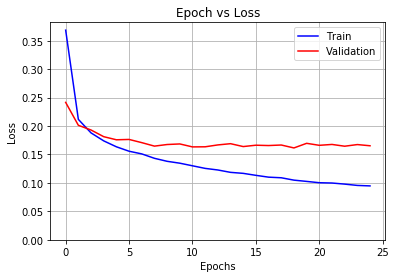

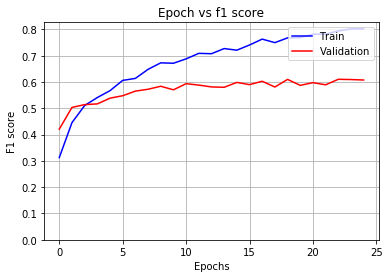

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 100)     4766000     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 98, 128)      38528       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 96, 128)      64128       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_19 

In [63]:
from keras.layers.normalization import BatchNormalization
beta = 1

#Code to create model
def create_model():
    tweet_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

    tweet_encoder = Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                    trainable=False,input_length=MAX_SEQUENCE_LENGTH)(tweet_input)
    
    first_branch = Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', strides=1,
                          kernel_regularizer=regularizers.l2(0.01))(tweet_encoder)
    first_branch = Activation('relu')(first_branch)
    first_branch = MaxPooling1D(pool_size=2)(first_branch)
    first_branch = Dropout(0.8)(first_branch)
    first_branch = BatchNormalization()(first_branch)
    first_branch = LSTM(64)(first_branch)   

    second_branch = Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu', strides=1,
                           kernel_regularizer=regularizers.l2(0.01))(tweet_encoder)
    second_branch = Activation('relu')(second_branch)
    second_branch = MaxPooling1D(pool_size=2)(second_branch)
    second_branch = Dropout(0.8)(second_branch)
    second_branch = BatchNormalization()(second_branch)
    second_branch = LSTM(64)(second_branch)

    third_branch = Conv1D(filters=128, kernel_size=7, padding='valid', activation='relu', strides=1,
                          kernel_regularizer=regularizers.l2(0.01))(tweet_encoder)
    third_branch = Activation('relu')(third_branch)
    third_branch = MaxPooling1D(pool_size=2)(third_branch)
    third_branch = Dropout(0.8)(third_branch)
    third_branch = BatchNormalization()(third_branch)   
    third_branch = LSTM(64)(third_branch)

    fourth_branch = Conv1D(filters=128, kernel_size=9, padding='valid', activation='relu', strides=1,
                           kernel_regularizer=regularizers.l2(0.01))(tweet_encoder)
    fourth_branch = Activation('relu')(fourth_branch)
    fourth_branch = MaxPooling1D(pool_size=2)(fourth_branch)
    fourth_branch = Dropout(0.8)(fourth_branch)
    fourth_branch = BatchNormalization()(fourth_branch)
    fourth_branch = LSTM(64)(fourth_branch)

    merged = concatenate([first_branch, second_branch,third_branch,fourth_branch], axis=1)
   
    merged = Dense(2)(merged)
    output = Activation('sigmoid')(merged)
    mymodel = Model(inputs=[tweet_input], outputs=[output])

    return mymodel


#Code to create a model
def train_model():
    new_model =  create_model()
    modelopt= optimizers.RMSprop(lr=0.01,decay=0.1)
    new_model.compile(loss='binary_crossentropy', optimizer=modelopt, metrics=['accuracy',fbeta(beta)])
    model_hist = new_model.fit(x_train, y_train,validation_split=0.20,validation_data=(x_val,y_val),
                               epochs=25,verbose=1, batch_size=128,callbacks=cbks)
    display_graph(model_hist,"Epoch vs Loss",'Epochs','Loss','loss','val_loss')
    display_graph(model_hist,"Epoch vs f1 score",'Epochs','F1 score','f1','val_f1')
    
    return new_model

#Code to create the model and load weights
def load_trained_model(weights_path):
    trained_model = create_model()
    trained_model.load_weights(weights_path)
    modelopt= optimizers.RMSprop(lr=0.01,decay=0.1)

    trained_model.compile(loss='binary_crossentropy', optimizer=modelopt, metrics=['accuracy',fbeta(beta)])
   
    return trained_model

with tf.Session( config = tf.ConfigProto( log_device_placement = True ) ):
    tf.global_variables_initializer().run()                                                                   
    
    #Code to check whether the model exists or not
    if(os.path.exists('./checkpoint_model.h5')==True):  
        print('Already model is present')
        model = load_trained_model('./checkpoint_model.h5')
        print('Model has been loaded')
    else:
        print('Creating a new model')
        model = train_model()
        
    print(model.summary())
   
    valprediction = model.predict(x_val)
    finalprediction = model.predict(X_test)
    
    train_scores =model.evaluate(x_train,y_train, verbose=0)
    val_scores = model.evaluate(x_val,y_val, verbose=0)
    

F1 score=0.651 AUC=0.663 ap=0.448


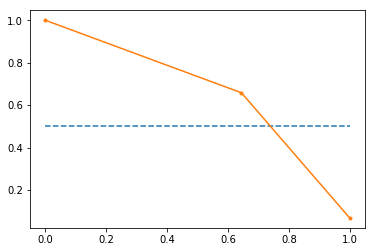

In [64]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

#Code to convert 2D array to 1D value
def check_label(x):
    if x[0]==1: 
        return 0
    else:
        return 1 
    

#Code to interpret the prediction value
def check_prediction(x):
    if x[1]>0.3: 
        return 1
    else:
        return 0
  
    
#Assign values of label and prediction value
vallabel=np.apply_along_axis(check_prediction,1, valprediction)
y_valnew= np.apply_along_axis(check_label,1, y_val)
# keep probabilities for the positive outcome only
probs = valprediction[:, 1]

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valnew, vallabel,1)
# calculate F1 score
f1 = f1_score(y_valnew, vallabel)
# calculate precision-recall AUC
auc = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_valnew, vallabel)

print('F1 score=%.3f AUC=%.3f ap=%.3f' % (f1, auc, ap))

# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

In [65]:
from sklearn.metrics import confusion_matrix 

#Code to create confusion matrix
confusion_matrix(y_valnew, vallabel)

array([[5811,  146],
       [ 155,  281]], dtype=int64)

In [66]:
resultlabel=np.apply_along_axis(check_prediction,1, finalprediction)
print(resultlabel)
finaltest['label'] = resultlabel

#Code to save the final prediction to csv file
submission =finaltest[['id','label']]
submission.to_csv('TSA_prediction.csv', index=False) # writing data to a CSV file
print('Results saved in the csv file successfully')

[0 1 0 ... 1 0 0]
Results saved in the csv file successfully


In [67]:
from keras.utils.vis_utils import plot_model
#Code to create the model as png file
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Final Conclusion :As per the above results we observe that of all the models we tried, model Support Vector Machine has best F1 score value.